Let's explore principal component analysis for the abalone data set.

This notebook utilized two sources: [this notebook](https://www.kaggle.com/nirajvermafcb/d/ludobenistant/hr-analytics/principal-component-analysis-explained/comments) and [this notebook](https://www.kaggle.com/arthurtok/d/deepmatrix/imdb-5000-movie-dataset/principal-component-analysis-with-kmeans-visuals).

In [1]:
%matplotlib inline

# numbers
import numpy as np
import pandas as pd

# stats
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

# plots
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os, re
from pprint import pprint

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Start with a method to extract data from a CSV file:

In [2]:
# Load data, filter outliers (zero height/length)

def abalone_load(data_file, infant=False, allofit=False):
    # x data labels
    xnlabs = ['Sex']
    xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
    xlabs = xnlabs + xqlabs

    # y data labels
    ylabs = ['Rings']

    # data
    new_df = pd.read_csv(data_file, header=None, sep=' ', names=xlabs+ylabs)        
    
    # ---------------------
    new_df['Volume']                      = new_df['Length']*new_df['Diameter']*new_df['Height']
    new_df['Volume (Normalized)']         = new_df['Volume']/new_df['Volume'].mean()
    new_df['Volume (Log)']                = new_df['Volume'].apply( lambda x : np.log(x) )
    new_df['Whole weight (Normalized)']   = new_df['Whole weight']/new_df['Whole weight'].mean()
    new_df['Shell weight (Normalized)']   = new_df['Shell weight']/new_df['Shell weight'].mean()
    new_df['Shucked weight (Normalized)'] = new_df['Shucked weight']/new_df['Shucked weight'].mean()
    new_df['Viscera weight (Normalized)'] = new_df['Viscera weight']/new_df['Viscera weight'].mean()
    new_df['Rings (Log)']                  = new_df['Rings'].apply( lambda x : np.log(x) )
    # ---------------------
    
    
    if(infant):
        return new_df[ new_df['Sex']=='I' ]
    elif(allofit):
        return new_df
    else:
        return new_df[ new_df['Sex']<>'I' ]

def adult_abalone_load(data_file):
    return abalone_load(data_file,infant=False,allofit=False)

def infant_abalone_load(data_file):
    return abalone_load(data_file,infant=True,allofit=False)

def abalone_removeoutliers(df,verbose=False):
    len1 = len(df)
    df = df[ df['Height'] < 0.30 ]
    df = df[ df['Height'] > 0.001 ]
    df = df[ df['Length'] > 0.001 ]
    df = df[ df['Diameter'] > 0.001 ]
    len2 = len(df)
    if(verbose):
        print "Removed",(len1-len2),"outliers"
    return df

# x data labels
xnlabs = ['Sex']
xqlabs = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']
xlabs = xnlabs + xqlabs

# y data labels
ylabs = ['Rings']

#adt_df = abalone_removeoutliers(adult_abalone_load('abalone/Dataset.data'),verbose=True)
abalone_df = abalone_removeoutliers(abalone_load('abalone/Dataset.data',allofit=True))

The data consists of multiple columns, each a measurement that was made on the abalone, together with the variable that we are trying to predict, "Rings" (which is an indication of the age of the abalone).

In [3]:
abalone_df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume,Volume (Normalized),Volume (Log),Whole weight (Normalized),Shell weight (Normalized),Shucked weight (Normalized),Viscera weight (Normalized),Rings (Log)
count,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000
mean,0.524038,0.407915,0.139256,0.828730,0.359304,0.180595,0.238794,9.935538,0.034656,0.998283,-3.629996,0.999985,0.999844,0.999823,1.000007,2.245854
std,0.120061,0.099210,0.038378,0.489987,0.221705,0.109525,0.139172,3.224861,0.020859,0.600868,0.871728,0.591242,0.582721,0.616931,0.606471,0.319572
min,0.075000,0.055000,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000041,0.001188,-10.095859,0.002413,0.006281,0.002783,0.002769,0.000000
25%,0.450000,0.350000,0.115000,0.442000,0.186000,0.093500,0.130000,8.000000,0.017944,0.516885,-4.020513,0.533338,0.544318,0.517576,0.517737,2.079442
50%,0.545000,0.425000,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,0.032809,0.945092,-3.417052,0.965318,0.979773,0.934976,0.946877,2.197225
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.328500,11.000000,0.048720,1.403433,-3.021658,1.391265,1.375450,1.396899,1.400936,2.397895
max,0.815000,0.650000,0.250000,2.825500,1.488000,0.760000,1.005000,29.000000,0.132437,3.814978,-2.021644,3.409384,4.207999,4.140608,4.208344,3.367296


In [4]:
abalone_df.columns

Index([u'Sex', u'Length', u'Diameter', u'Height', u'Whole weight',
       u'Shucked weight', u'Viscera weight', u'Shell weight', u'Rings',
       u'Volume', u'Volume (Normalized)', u'Volume (Log)',
       u'Whole weight (Normalized)', u'Shell weight (Normalized)',
       u'Shucked weight (Normalized)', u'Viscera weight (Normalized)',
       u'Rings (Log)'],
      dtype='object')

To begin, we can plot the covariance matrix of our dataframe, picking out some particular response variables and input variables:

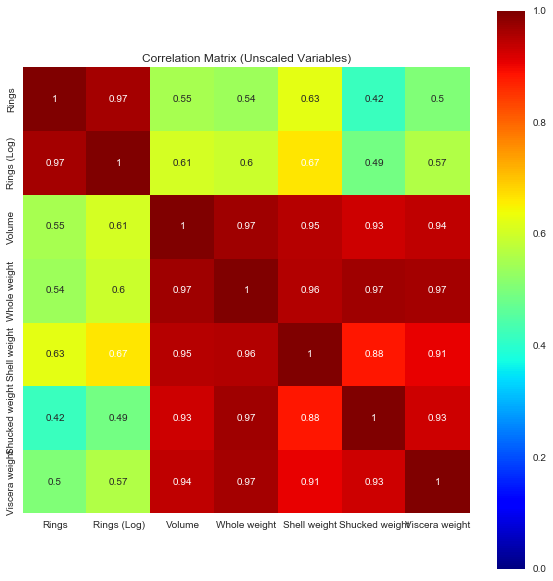

In [5]:
slim = abalone_df[[u'Rings',u'Rings (Log)',
       u'Volume',
       u'Whole weight', u'Shell weight',
       u'Shucked weight', u'Viscera weight']]
correlation = slim.corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation, square=True,annot=True,vmin=0,vmax=1,cmap='jet')
plt.title('Correlation Matrix (Unscaled Variables)')
plt.show()

We can already see the challenge inherent in this data set: the input variables (consisting of three physical measurements, length, height, and diameter, as well as several weight mesaurements) are all closely correlated, but none are not very well-correlated with the system response.

In [6]:
cols = slim.columns.tolist()[1:]
slim = slim.reindex(columns=cols)

X = slim.iloc[:,1:6].values
y = slim.iloc[:,0].values

#print X
#print "-"*20
#print y

# -----------------

bigcols = slim.columns.tolist()
bigX = slim.iloc[:,:].values
print bigX.shape

(4173, 6)


To perform principal components analysis it is important to strip the values of the variables and put them in a numpy array, or an array of arrays. The input variables are in `X`, while the system responses are in `Y`. The matrix `bigX` contains both input and response variables.

In [7]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    #X_cov = np.cov(X_std.T)
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

X_std, X_mean, X_cov = get_normed_mean_cov(X)
bigX_std, bigX_mean, bigX_cov = get_normed_mean_cov(bigX)

Next we define a method to obtain a normalized X, which is normalized to have a mean of 0 and a variance of 1, which is stored in `X_std`. We also compute the mean and covariance of each input variable, and store them in `X_mean` and `X_cov`, respectively.

In [8]:
print "Covariance matrix"
print X_cov

Covariance matrix
[[ 1.00023969  0.96976465  0.95033981  0.93098321  0.9434908 ]
 [ 0.96976465  1.00023969  0.9561835   0.96960213  0.96652123]
 [ 0.95033981  0.9561835   1.00023969  0.88340564  0.9083506 ]
 [ 0.93098321  0.96960213  0.88340564  1.00023969  0.93205474]
 [ 0.9434908   0.96652123  0.9083506   0.93205474  1.00023969]]


We examine the covariance matrix, then plot it.

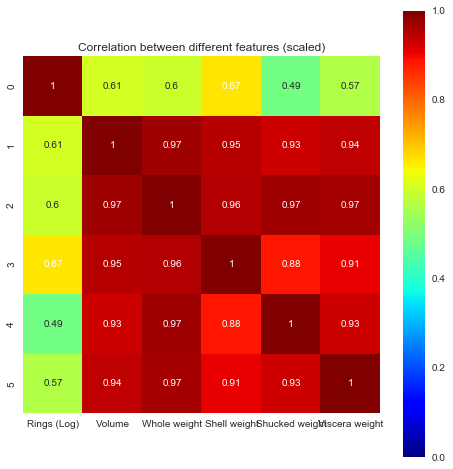

In [9]:
plt.figure(figsize=(8,8))
sns.heatmap(pd.DataFrame(bigX_cov,columns=bigcols), 
            vmax=1, vmin=0, 
            square=True,annot=True,cmap='jet')

plt.title('Correlation between different features (scaled)')

The best correlation for the response variable is between the shell weight and the log of the number of rings. None of these variables are particularly well-correlated to the system response, though, so PCA probably won't help us much here.

In [10]:
eigenvals, eigenvecs = np.linalg.eig(X_cov)

print "Eigenvals:\n",eigenvals
print "Eigenvecs:\n",eigenvecs

Eigenvals:
[ 4.76524857  0.12481455  0.03953804  0.06501951  0.00657779]
Eigenvecs:
[[-0.45004174 -0.2042057   0.86901162  0.02297704 -0.00730146]
 [-0.45636533  0.06210362 -0.21716703  0.09844054  0.85499811]
 [-0.44093801 -0.7201095  -0.40469882  0.17255817 -0.30570988]
 [-0.44265517  0.61239018 -0.10249784  0.53204466 -0.3680453 ]
 [-0.44589594  0.24670581 -0.15287359 -0.82275979 -0.20002262]]


We compute the eigenvalues and eigenvectors, which tell us about the spectral "characteristic" vector of this covariance matrix. This can, in turn, be used to compute the principal components, as well as the variance in the data that is explained by each variable.

In [11]:
tot = sum(eigenvals)
explained_variance = [(i/tot) for i in sorted(eigenvals, reverse=True)]

In [12]:
from pprint import pprint

eigenvalvec = [(np.abs(eigenvals[i]), eigenvecs[:,i]) for i in range(len(eigenvals))]
pprint([pair[0] for pair in eigenvalvec])

[4.7652485676831589,
 0.12481455408607262,
 0.039538039015354867,
 0.065019511945928352,
 0.0065777932330518402]


The list above is the (sorted) list of eigenvalues corresponding to each eigenvector. By comparing the relavitve vlaues of these eigenvalues, we can determine what each principal component is and how important that principal component is:

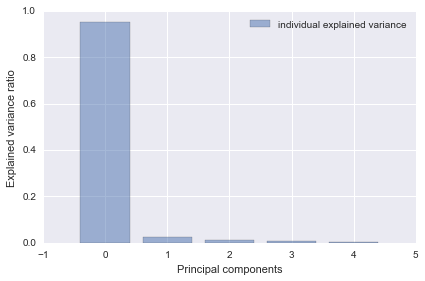

In [13]:
plt.figure(figsize=(6, 4))

plt.bar(range(5), explained_variance, alpha=0.5, align='center',
        label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

We can also plot the amount of variance explained by each input variable. In this case, we have one principal component that explains nearly all (95%) of the variance. The reason for this is not that we have discovered a very convenient principal component - the reason is, the principal component is a mixture of all variables in nearly equal proportions. That is, the principal component is the one that combines every single variable.

In other words, we can't eliminate any variables.

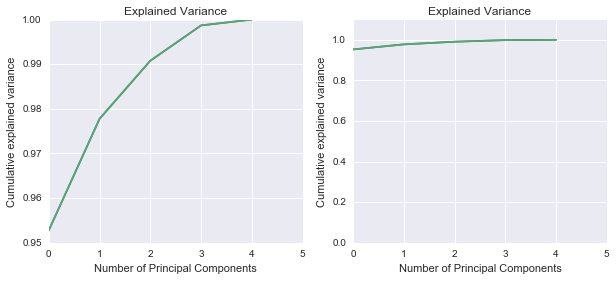

In [14]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_std)
S_pca = pca.transform(X_std)

fig = plt.figure(figsize=(10,4))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

# These two plots should be exactly the same
ax1.plot(np.cumsum(explained_variance))
ax1.plot(np.cumsum(pca.explained_variance_ratio_))

ax1.set_xlim(0,5,1)

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative explained variance')
ax1.set_title('Explained Variance')


ax2.plot(np.cumsum(explained_variance))
ax2.plot(np.cumsum(pca.explained_variance_ratio_))

ax2.set_xlim(0,5,1)
ax2.set_ylim([0,1.1])

ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Cumulative explained variance')
ax2.set_title('Explained Variance')


plt.show()

If we limit the number of principal components to 3, we get the same result: there is only one principal component, which consists of every variable weighted equally.

In [15]:
from sklearn.decomposition import PCA 

sklearn_pca = PCA(n_components=3).fit(X_std)

#Y_sklearn = sklearn_pca.fit_transform(X_std)

In [16]:
print sklearn_pca.components_
print np.linalg.norm(sklearn_pca.components_[0],2)

[[ 0.45004174  0.45636533  0.44093801  0.44265517  0.44589594]
 [ 0.2042057  -0.06210362  0.7201095  -0.61239018 -0.24670581]
 [ 0.02297704  0.09844054  0.17255817  0.53204466 -0.82275979]]
1.0


Examine the top row - the first principal component. This vector shows the weights of each variable in the principal components. So, whoop de doo, we found a single principal component that can account for 95% of the variance - but that's because it does f--k all to reduce the number of variables. It assigns virtually identical weights of 0.44 or 0.45 to every single component.

Examining infant and adult datasets separately shows that these two data frames are different: infant abalones have a stronger correlation between age and shell weight (and other input variables) than do adult abalones.

In [17]:
adt_df = abalone_removeoutliers(adult_abalone_load('abalone/Dataset.data'))
inf_df = abalone_removeoutliers(infant_abalone_load('abalone/Dataset.data'))

In [18]:
adt_df.columns

Index([u'Sex', u'Length', u'Diameter', u'Height', u'Whole weight',
       u'Shucked weight', u'Viscera weight', u'Shell weight', u'Rings',
       u'Volume', u'Volume (Normalized)', u'Volume (Log)',
       u'Whole weight (Normalized)', u'Shell weight (Normalized)',
       u'Shucked weight (Normalized)', u'Viscera weight (Normalized)',
       u'Rings (Log)'],
      dtype='object')

In [19]:
def get_normed_mean_cov(X):
    X_std = StandardScaler().fit_transform(X)
    X_mean = np.mean(X_std, axis=0)
    #X_cov = np.cov(X_std.T)
    X_cov = (X_std - X_mean).T.dot((X_std - X_mean)) / (X_std.shape[0]-1)
    
    return X_std, X_mean, X_cov

def cov_pca_plots(df,labels,title=''):
    slim = df[labels]
    slimcols = labels[1:]
    
    X = slim.iloc[:, 1:].values
    Y = slim.iloc[:, 0].values
    
    bigcols = labels
    bigX = slim.iloc[:,:].values
    
    X_std, X_mean, X_cov = get_normed_mean_cov(X)
    bigX_std, bigX_mean, bigX_cov = get_normed_mean_cov(bigX)

    eigenvals, eigenvecs = np.linalg.eig(X_cov)

    tot = sum(eigenvals)
    explained_variance = [(i/tot) for i in sorted(eigenvals, reverse=True)]

    eigenvalvec = [(np.abs(eigenvals[i]), eigenvecs[:,i]) for i in range(len(eigenvals))]
    pprint([pair[0] for pair in zip(eigenvals,eigenvecs)])
    
    sns.heatmap(pd.DataFrame(bigX_cov,columns=bigcols), 
                vmax=1, vmin=0, 
                square=True,annot=True,cmap='jet')
    
    plt.title(title+' Covariance Plot ')
    
    print "-"*20
    
    pca = PCA().fit(X_std)
    S_pca = pca.transform(X_std)
    
    print "Top 4 Principal Components:"
    print pca.components_[:4]
    
    fig = plt.figure(figsize=(10,4))
    ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

    # These two plots should be exactly the same
    ax1.plot(np.cumsum(explained_variance))
    ax1.plot(np.cumsum(pca.explained_variance_ratio_))

    ax1.set_xlim(0,5,1)

    ax1.set_xlabel('Number of Principal Components')
    ax1.set_ylabel('Cumulative explained variance')
    ax1.set_title('Explained Variance')


    ax2.plot(np.cumsum(explained_variance))
    ax2.plot(np.cumsum(pca.explained_variance_ratio_))

    ax2.set_xlim(0,5,1)
    ax2.set_ylim([0,1.1])

    ax2.set_xlabel('Number of Principal Components')
    ax2.set_ylabel('Cumulative explained variance')
    ax2.set_title('Explained Variance')

    
    plt.title('Correlation between different features (scaled)')

Here is a plot of the covariance matrix for infant abalones. Note that the correlation between age (log of number of rings) and all other input variables is stronger for the infant abalones than for adult abalones:

[4.8179402424674489,
 0.092107662242057964,
 0.057665386524831566,
 0.028777332920546565,
 0.0072435057928367588]
--------------------
Top 4 Principal Components:
[[ 0.44873277  0.45410668  0.44610478  0.44118574  0.44583818]
 [-0.32584852  0.09621614 -0.50305041  0.79300799 -0.05141799]
 [-0.17805112 -0.00261479 -0.40294717 -0.27300533  0.85521496]
 [ 0.81225178 -0.17896644 -0.54799408  0.00207694 -0.08897326]]


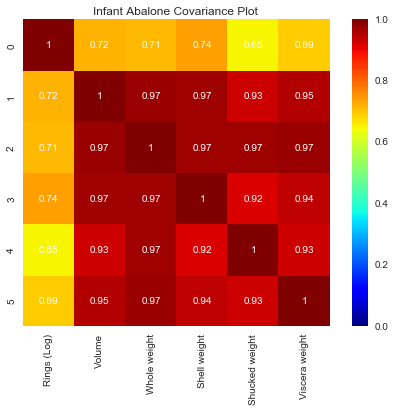

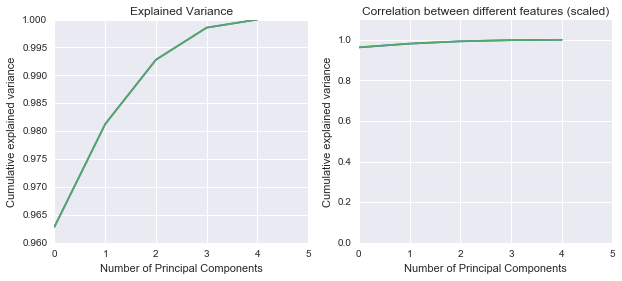

In [20]:
labels = ['Rings (Log)',
        'Volume',
        'Whole weight', 
        'Shell weight',
        'Shucked weight', 
        'Viscera weight']

cov_pca_plots(inf_df,labels,'Infant Abalone')

[4.641535198464652,
 0.19227146643926923,
 0.061046181709728538,
 0.0971389861502793,
 0.0097737039592387092]
--------------------
Top 4 Principal Components:
[[ 0.45170175  0.46143856  0.43624736  0.4413634   0.4448894 ]
 [ 0.18964967 -0.05843969  0.73993831 -0.57513669 -0.28692662]
 [ 0.01703976  0.11495509  0.12388274  0.55840798 -0.8119905 ]
 [-0.87160125  0.22437612  0.39105605  0.116461    0.15322735]]


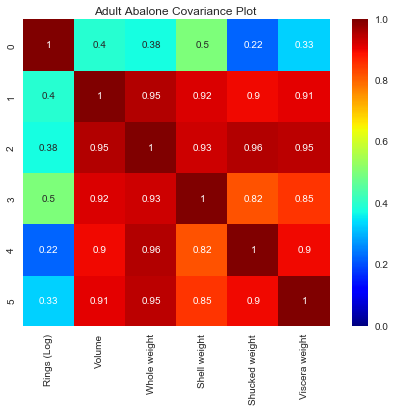

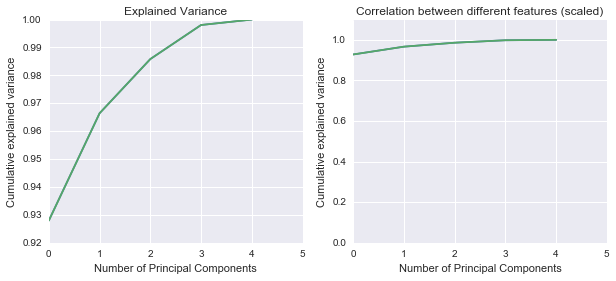

In [21]:
labels = ['Rings (Log)',
        'Volume',
        'Whole weight',
        'Shell weight',
        'Shucked weight',
        'Viscera weight']

cov_pca_plots(adt_df,labels,'Adult Abalone')

We can also explore the effect of adding additional variables. However, it's important to keep in mind that if we only have length and weight information, any derived variables will themselves be length or weight variables, or encoded versions thereof.

In [22]:
def add_df_columns(df):
    df['Shell-Whole Weight Ratio']   = df['Shell weight']/df['Whole weight']
    df['Shell-Shucked Weight Ratio'] = df['Shell weight']/df['Shucked weight']
    df['Shell-Viscera Weight Ratio'] = df['Shell weight']/df['Viscera weight']
    df['Specific Volume']            = df['Volume']/df['Whole weight']
    df['Weight-Length']              = df['Whole weight']/df['Volume'].apply(lambda x : pow(x,1./3.))
    
    df['Growth Rate'] = df['Whole weight']/df['Rings']

    return df

adt_df = add_df_columns(adt_df)
inf_df = add_df_columns(inf_df)

[6.6189981536790672,
 0.194738307526131,
 0.0042648653531121451,
 0.015172215175217413,
 0.045689544041650855,
 0.06878748539979232,
 0.057577210751839775]
--------------------
Top 4 Principal Components:
[[ 0.37895306  0.38726461  0.37715139  0.37863265  0.37904223  0.38292745
   0.36125947]
 [-0.34421265 -0.11490602 -0.4131066   0.18473696 -0.17971652  0.117674
   0.78573803]
 [-0.31698574  0.14460671 -0.26155581  0.69140637 -0.09838755  0.29599936
  -0.48462254]
 [-0.2482094   0.01677824 -0.39389566 -0.2454981   0.84031151  0.10183043
  -0.07870583]]


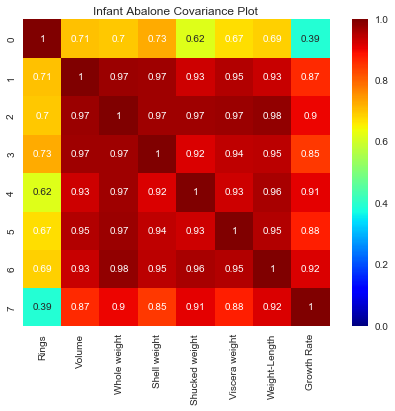

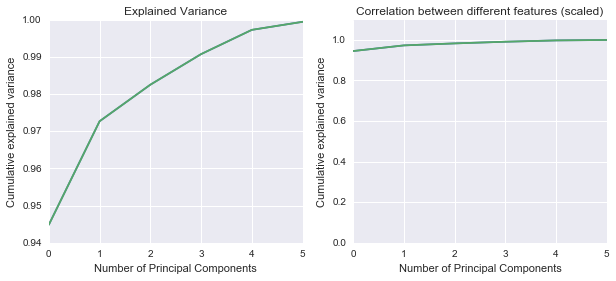

In [23]:
labels = ['Rings',
        'Volume',
        'Whole weight', 
        'Shell weight',
        'Shucked weight', 
        'Viscera weight',
        'Weight-Length',
        'Growth Rate']

cov_pca_plots(inf_df,labels,'Infant Abalone')

[5.5840411725017933,
 0.19815452003128808,
 0.0045577083895202031,
 0.019975871095406075,
 0.090445523833273797,
 0.10494384821651777]
--------------------
Top 4 Principal Components:
[[ 0.40800866  0.42190984  0.39679316  0.4038874   0.40544272  0.41299804]
 [ 0.27985989 -0.04168952  0.7363278  -0.53751867 -0.22862536 -0.19122214]
 [-0.45759667  0.12465636  0.27938847  0.25242469 -0.65479398  0.45225522]
 [-0.57246048  0.00641251  0.13207667 -0.47832695  0.53321848  0.37641071]]


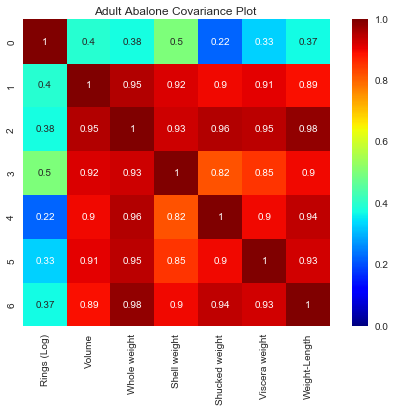

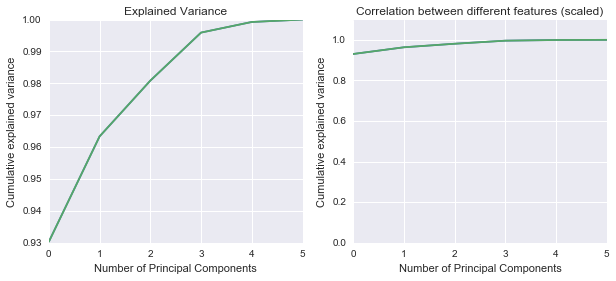

In [24]:
labels = ['Rings (Log)',
        'Volume',
        'Whole weight', 'Shell weight',
        'Shucked weight', 'Viscera weight',
        'Weight-Length']

cov_pca_plots(adt_df,labels,'Adult Abalone')

From the above, we see the same pattern - there is one principal component that accounts for over 90% of the variance, and that principal component is an evenly-weighted mixture of each input variable.